# Phân đoạn hình ảnh bằng DBSCAN và đánh giá hiệu suất


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import os
import random
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import directed_hausdorff

## 1. Định nghĩa hàm hiển thị và đánh giá

In [2]:
def showImages(idxs, image_files=None, images=None):
    plt.figure(figsize=(20, 10))
    if image_files is not None:
        for i, idx in enumerate(idxs):
            img = cv2.imread(image_files[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Ảnh {i+1}")
    elif images is not None:
        for i in range(len(idxs)):
            plt.subplot(1, 5, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off')
            plt.title(f"Ảnh {i+1}")
    else:
        raise ValueError("Cần cung cấp ít nhất một trong hai tham số: image_files hoặc images")
    plt.show()

# Hàm tính Dice Coefficient
def dice_coefficient(pred, gt):
    pred = pred.flatten()
    gt = gt.flatten()
    intersection = np.sum(pred * gt)
    return (2. * intersection) / (np.sum(pred) + np.sum(gt) + 1e-8)

# Hàm tính IoU
def iou(pred, gt):
    pred = pred.flatten()
    gt = gt.flatten()
    intersection = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt) - intersection
    return intersection / (union + 1e-8)

# Hàm tính Precision, Recall
def precision_recall(pred, gt):
    pred = pred.flatten()
    gt = gt.flatten()
    tp = np.sum(pred * gt)
    fp = np.sum(pred * (1 - gt))
    fn = np.sum((1 - pred) * gt)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    return precision, recall

# Hàm tính Hausdorff Distance
def hausdorff_distance(pred, gt):
    pred_points = np.argwhere(pred > 0)
    gt_points = np.argwhere(gt > 0)
    if len(pred_points) == 0 or len(gt_points) == 0:
        return np.inf
    return max(directed_hausdorff(pred_points, gt_points)[0], directed_hausdorff(gt_points, pred_points)[0])

## Tổng quan dữ liệu

Số lượng ảnh trong từng thư mục con của 'image':
  Thư mục 0 - No tumor: 1595 ảnh
  Thư mục 1 - Glioma: 649 ảnh
  Thư mục 2 - Meningioma: 999 ảnh
  Thư mục 3 - Pituitary: 994 ảnh

Số lượng ảnh trong từng thư mục con của 'mask':
  Thư mục 0 - No tumor: 1595 ảnh
  Thư mục 1 - Glioma: 649 ảnh
  Thư mục 2 - Meningioma: 999 ảnh
  Thư mục 3 - Pituitary: 994 ảnh

Tổng số ảnh gốc: 4237
Tổng số ảnh mask: 4237

Ảnh minh họa từ thư mục 0 - No tumor:


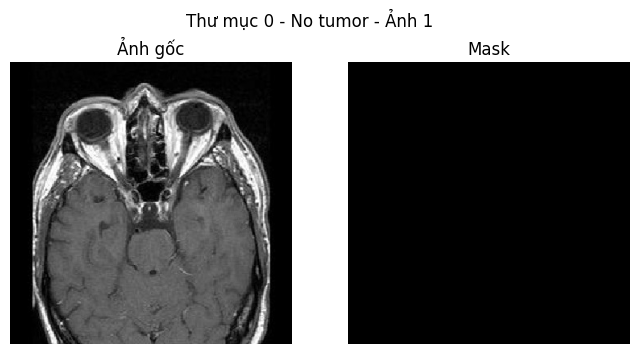

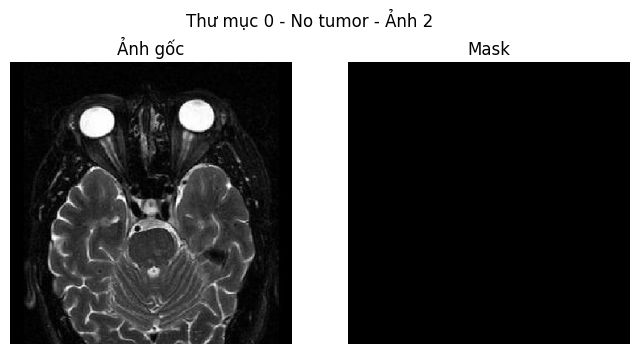


Ảnh minh họa từ thư mục 1 - Glioma:


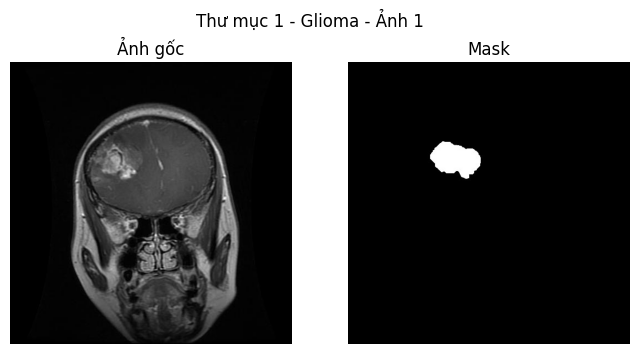

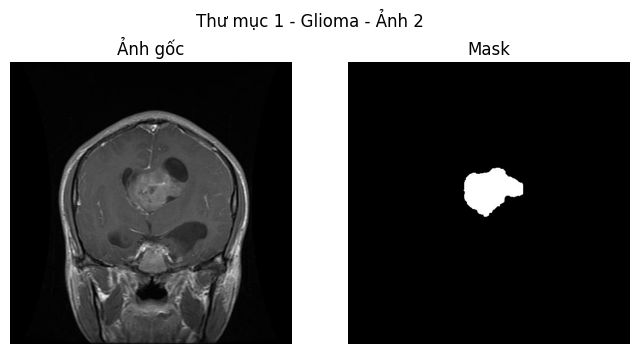


Ảnh minh họa từ thư mục 2 - Meningioma:


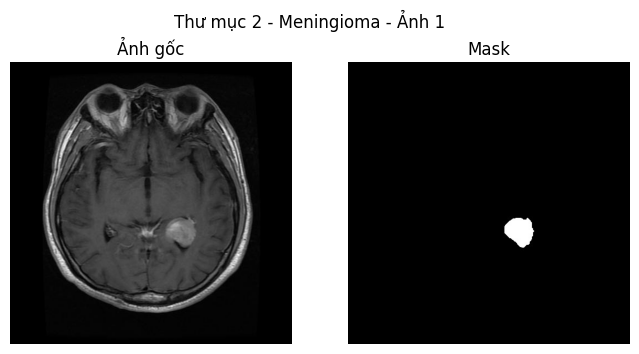

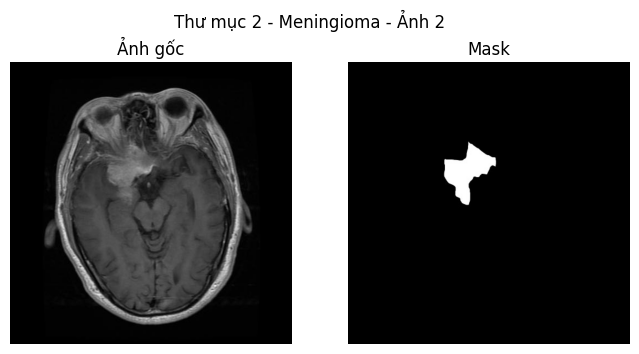


Ảnh minh họa từ thư mục 3 - Pituitary:


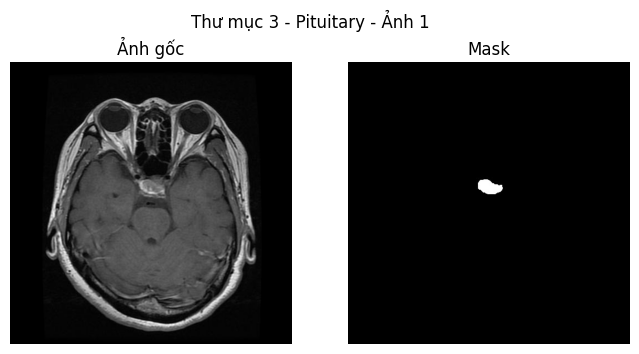

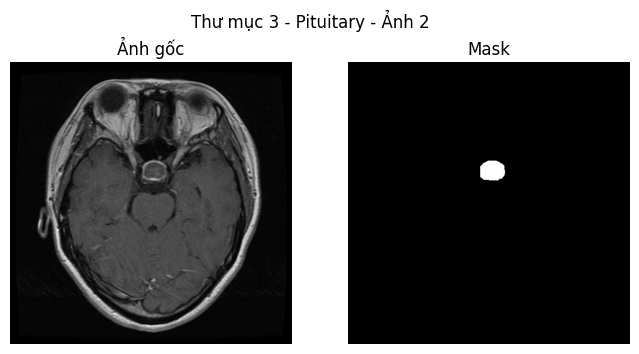

In [9]:
image_dir = r'./Brain Tumor Segmentation Dataset/image'
mask_dir = r'./Brain Tumor Segmentation Dataset/mask'

folder_map = {
    "0": "No tumor",
    "1": "Glioma",
    "2": "Meningioma",
    "3": "Pituitary"
}

def count_images_and_collect_examples(base_dir):
    counts = {}
    examples = {}
    for subfolder in sorted(os.listdir(base_dir)):
        subfolder_path = os.path.join(base_dir, subfolder)
        if os.path.isdir(subfolder_path):
            files = [
                f for f in os.listdir(subfolder_path)
                if os.path.isfile(os.path.join(subfolder_path, f)) and f.endswith('.jpg')
            ]
            counts[subfolder] = len(files)
            examples[subfolder] = files[:2]  # Lấy 2 ảnh đầu tiên làm ví dụ
    return counts, examples

image_counts, image_examples = count_images_and_collect_examples(image_dir)
mask_counts, mask_examples = count_images_and_collect_examples(mask_dir)

# In thông tin
print("Số lượng ảnh trong từng thư mục con của 'image':")
for subfolder, count in image_counts.items():
    print(f"  Thư mục {subfolder} - {folder_map.get(subfolder)}: {count} ảnh")

print("\nSố lượng ảnh trong từng thư mục con của 'mask':")
for subfolder, count in mask_counts.items():
    print(f"  Thư mục {subfolder} - {folder_map.get(subfolder)}: {count} ảnh")

print(f"\nTổng số ảnh gốc: {sum(image_counts.values())}")
print(f"Tổng số ảnh mask: {sum(mask_counts.values())}")

# Hiển thị ảnh ví dụ
for subfolder in sorted(image_examples.keys()):
    image_subdir = os.path.join(image_dir, subfolder)
    mask_subdir = os.path.join(mask_dir, subfolder)
    images = image_examples[subfolder]
    masks = mask_examples.get(subfolder, [])

    print(f"\nẢnh minh họa từ thư mục {subfolder} - {folder_map.get(subfolder)}:")
    for i, img_name in enumerate(images):
        img_path = os.path.join(image_subdir, img_name)
        mask_path = os.path.join(mask_subdir, img_name) if img_name in masks else None

        try:
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if mask_path and os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            else:
                mask = None

            plt.figure(figsize=(8, 4))
            plt.suptitle(f"Thư mục {subfolder} - {folder_map.get(subfolder)} - Ảnh {i+1}")

            plt.subplot(1, 2, 1)
            plt.imshow(img_rgb)
            plt.title("Ảnh gốc")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            if mask is not None:
                plt.imshow(mask, cmap='gray')
                plt.title("Mask")
            else:
                plt.title("Không tìm thấy mask")
            plt.axis("off")

            plt.show()

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_name} trong thư mục {subfolder}: {e}")

## 2. Tiền xử lý dữ liệu

Số lượng ảnh đã chọn: 4
Các ảnh đã chọn:


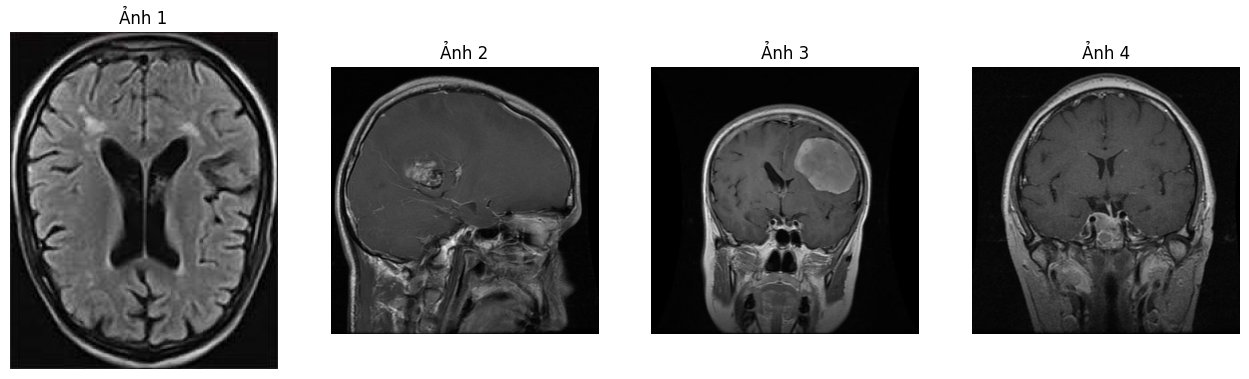

In [75]:
data_dir = r'./Brain Tumor Segmentation Dataset/image'
image_files = []
ground_truth_dir = r'./Brain Tumor Segmentation Dataset/mask'

for folder in ['0', '1', '2', '3']:
    folder_path = os.path.join(data_dir, folder)
    if os.path.exists(folder_path):
        files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
        if files:
            random_file = random.choice(files)
            image_files.append(os.path.join(folder_path, random_file))

print(f"Số lượng ảnh đã chọn: {len(image_files)}")
print("Các ảnh đã chọn:")
showImages(range(len(image_files)), image_files=image_files)

4 ảnh xám:


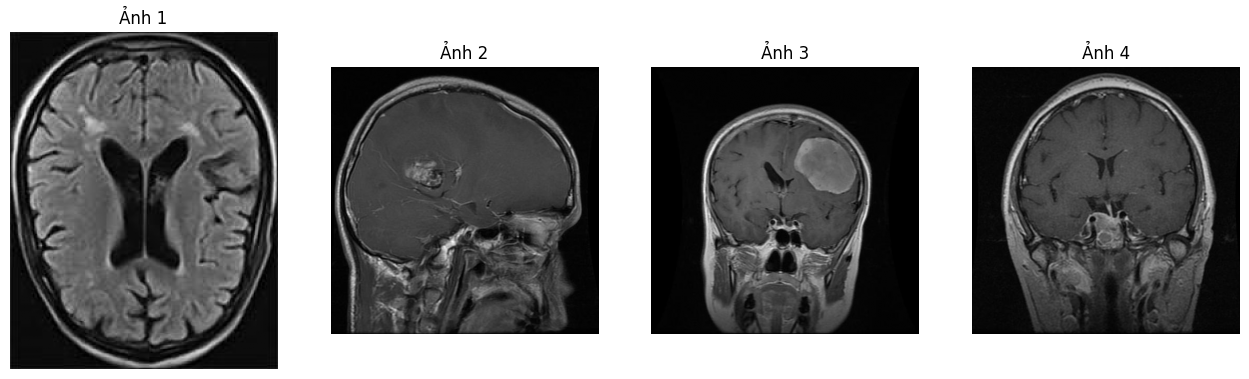

In [76]:
gray_images = []
for idx in range(len(image_files)):
    gray_img = cv2.imread(image_files[idx], cv2.IMREAD_GRAYSCALE)
    gray_images.append(gray_img)

print("4 ảnh xám:")
showImages(range(len(gray_images)), images=gray_images)

4 ảnh xám đã resize:


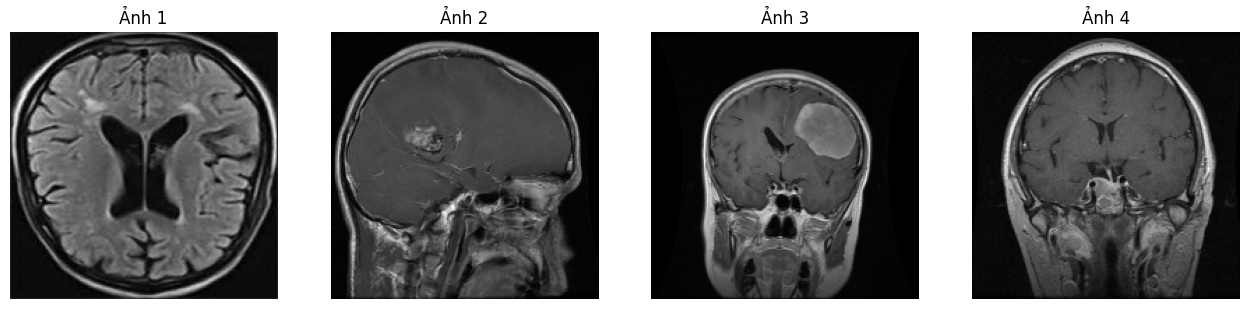

In [ ]:
resized_images = []
size = (128, 128)
for img in gray_images:
    resized_img = cv2.resize(img, size, cv2.INTER_AREA)
    resized_images.append(resized_img)

print("4 ảnh xám đã resize:")
showImages(range(len(resized_images)), images=resized_images)

4 ảnh xám đã cân bằng histogram:


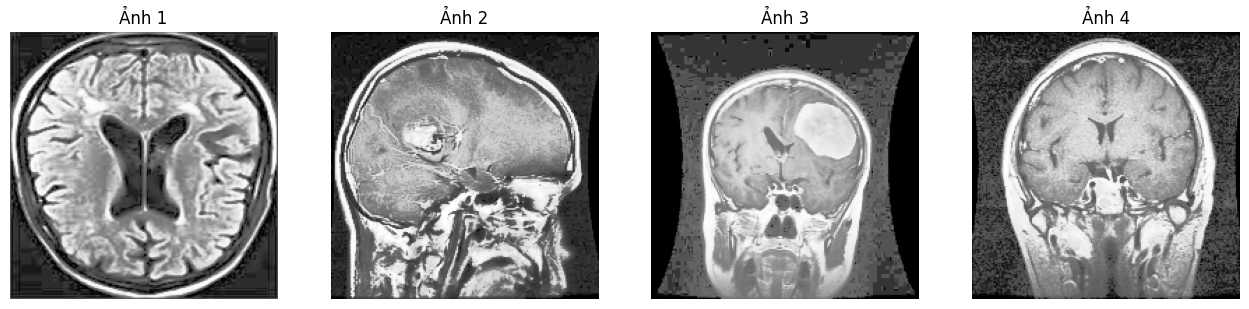

In [78]:
equalized_images = []
for img in resized_images:
    equalized_img = cv2.equalizeHist(img)
    equalized_images.append(equalized_img)

print("4 ảnh xám đã cân bằng histogram:")
showImages(range(len(equalized_images)), images=equalized_images)

4 ảnh xám đã làm mịn:


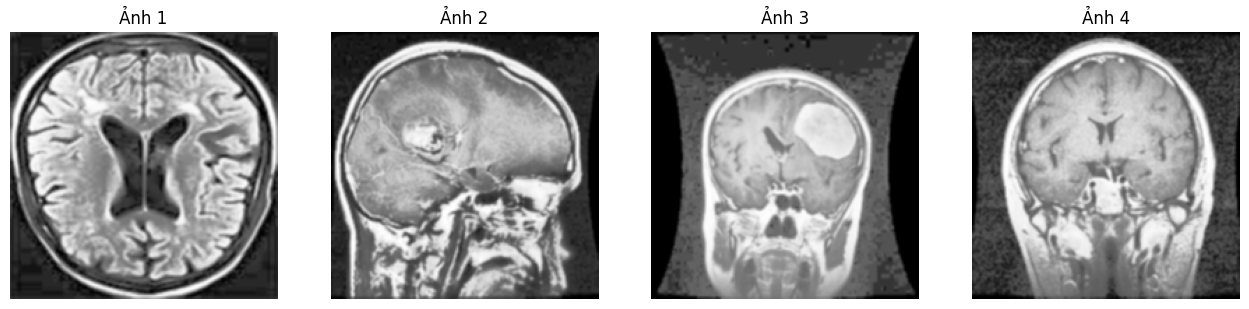

In [79]:
blurred_images = []
for img in equalized_images:
    blurred_img = cv2.GaussianBlur(img, (3, 3), 0)
    blurred_images.append(blurred_img)
print("4 ảnh xám đã làm mịn:")
showImages(range(len(blurred_images)), images=blurred_images)

## 3. Định nghĩa hàm phân đoạn DBSCAN

In [80]:
def getEps(X_scaled):
    k = 10
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X_scaled)
    distances, _ = neigh.kneighbors(X_scaled)
    distances = np.sort(distances[:, k-1], axis=0)
    kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    knee_eps = kneedle.knee_y
    print(f"Estimated eps: {knee_eps:.3f}")
    plt.figure(figsize=(10, 5))
    plt.plot(distances, label='k-distance')
    plt.axhline(y=knee_eps, color='r', linestyle='--', label=f'Estimated eps = {knee_eps:.3f}')
    plt.title(f"k-distance Graph (k={k})")
    plt.xlabel("Points (sorted)")
    plt.ylabel(f"Distance to {k}th Nearest Neighbor")
    plt.legend()
    plt.grid(True)
    plt.show()
    return knee_eps

def find_best_min_samples(X_scaled, eps, min_samples_range):
    best_score = -1
    best_min_samples = None
    silhouette_scores = []
    for min_samples in min_samples_range:
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters >= 2:
            score = silhouette_score(X_scaled, labels)
            silhouette_scores.append((min_samples, score))
            if score > best_score:
                best_score = score
                best_min_samples = min_samples
    return best_min_samples, silhouette_scores

def evaluate_unsupervised(X_scaled, labels):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    metrics = {}
    if n_clusters >= 2:
        metrics['Silhouette Score'] = silhouette_score(X_scaled, labels)
        metrics['Davies-Bouldin Index'] = davies_bouldin_score(X_scaled, labels)
        metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(X_scaled, labels)
    return metrics

def evaluate_supervised(pred, gt):
    pred_binary = (pred > 0).astype(np.uint8)
    gt_binary = (gt > 0).astype(np.uint8)
    
    # Kiểm tra trường hợp rỗng
    if np.sum(pred_binary) == 0 or np.sum(gt_binary) == 0:
        return {
            "Dice Coefficient": 0.0,
            "IoU": 0.0,
            "Precision": 0.0,
            "Recall": 0.0,
            "Hausdorff Distance": np.inf
        }
    
    dice = dice_coefficient(pred_binary, gt_binary)
    iou_score = iou(pred_binary, gt_binary)
    precision, recall = precision_recall(pred_binary, gt_binary)
    hausdorff = hausdorff_distance(pred_binary, gt_binary)
    
    return {
        "Dice Coefficient": max(dice, 0.0),  # Đảm bảo không âm
        "IoU": max(iou_score, 0.0),
        "Precision": max(precision, 0.0),
        "Recall": max(recall, 0.0),
        "Hausdorff Distance": hausdorff
    }

## 4. Thực thi DBSCAN và đánh giá hiệu suất


=== Ảnh 1 ===
Estimated eps: 0.242


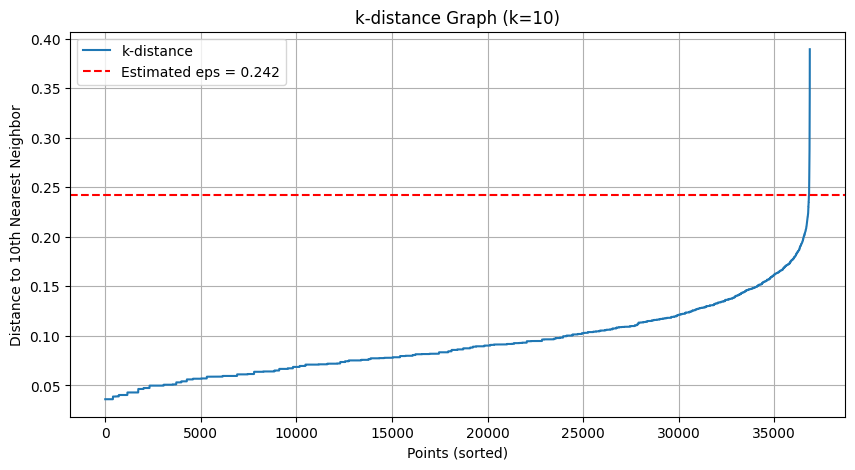

→ eps tối ưu = 0.24, min_samples tối ưu = 120
Đánh giá không giám sát:
Silhouette Score: 0.0343
Davies-Bouldin Index: 2.0739
Calinski-Harabasz Index: 4011.8553
Đánh giá giám sát:
Dice Coefficient: 0.0000
IoU: 0.0000
Precision: 0.0000
Recall: 0.0000
Hausdorff Distance: inf


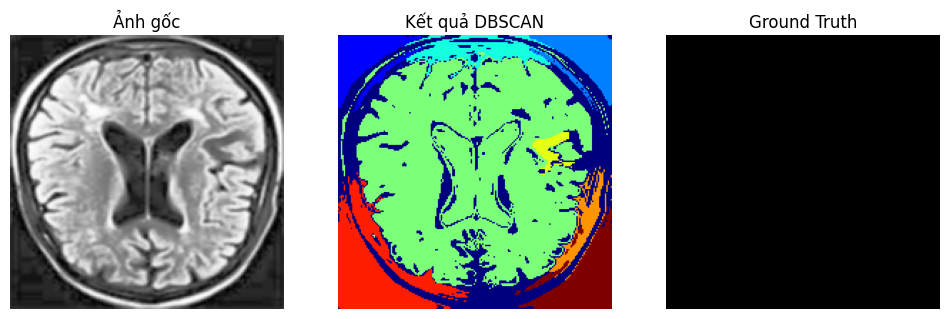


=== Ảnh 2 ===
Estimated eps: 0.217


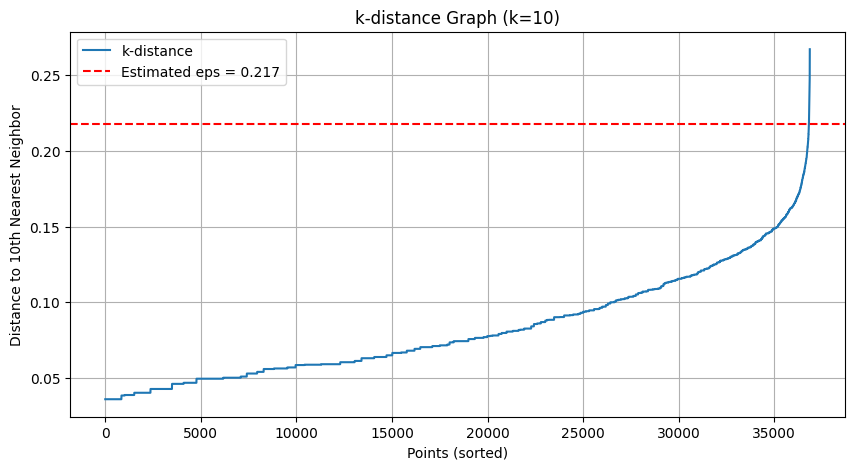

→ eps tối ưu = 0.22, min_samples tối ưu = 170
Đánh giá không giám sát:
Silhouette Score: -0.0266
Davies-Bouldin Index: 1.3159
Calinski-Harabasz Index: 3236.9750
Đánh giá giám sát:
Dice Coefficient: 0.0315
IoU: 0.0160
Precision: 0.0162
Recall: 0.6399
Hausdorff Distance: 150.0733


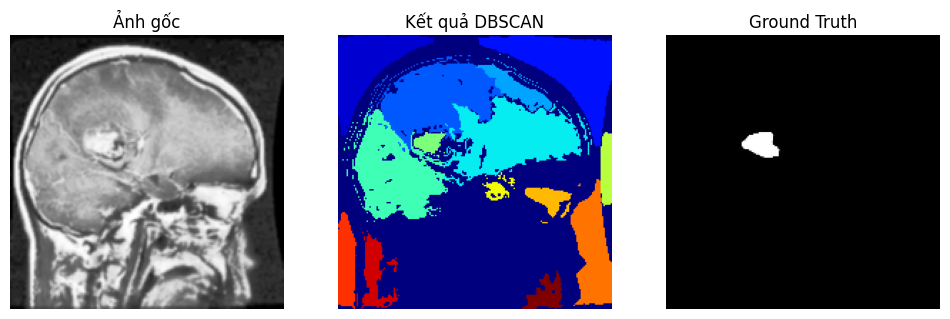


=== Ảnh 3 ===
Estimated eps: 0.223


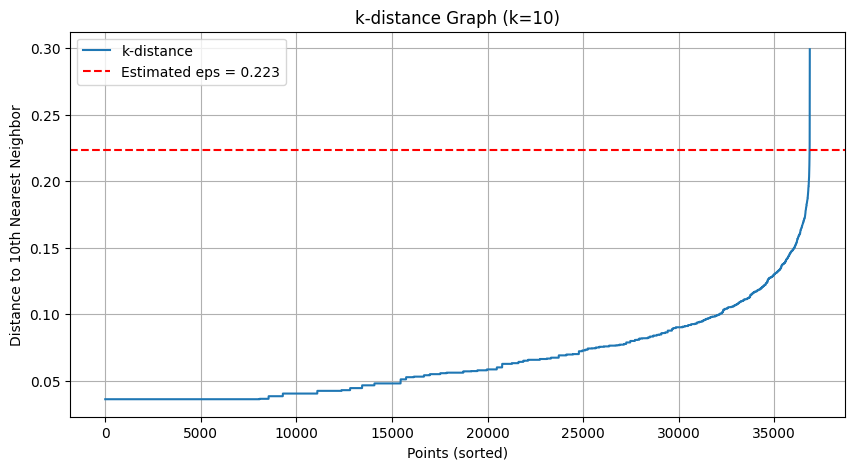

→ eps tối ưu = 0.22, min_samples tối ưu = 250
Đánh giá không giám sát:
Silhouette Score: 0.0388
Davies-Bouldin Index: 1.5058
Calinski-Harabasz Index: 4836.6434
Đánh giá giám sát:
Dice Coefficient: 0.1444
IoU: 0.0778
Precision: 0.0784
Recall: 0.9123
Hausdorff Distance: 147.0850


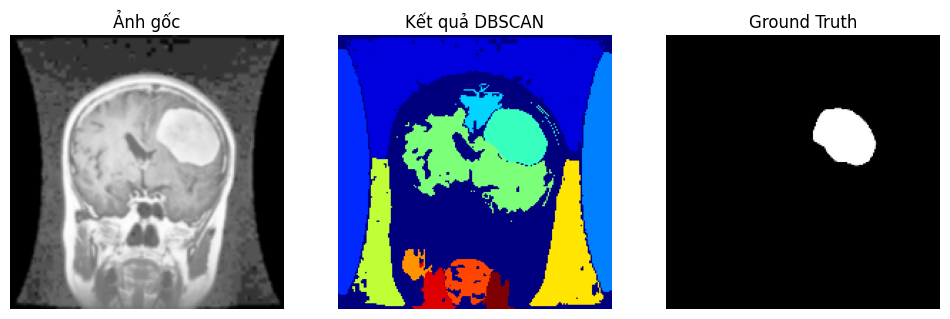


=== Ảnh 4 ===
Estimated eps: 0.239


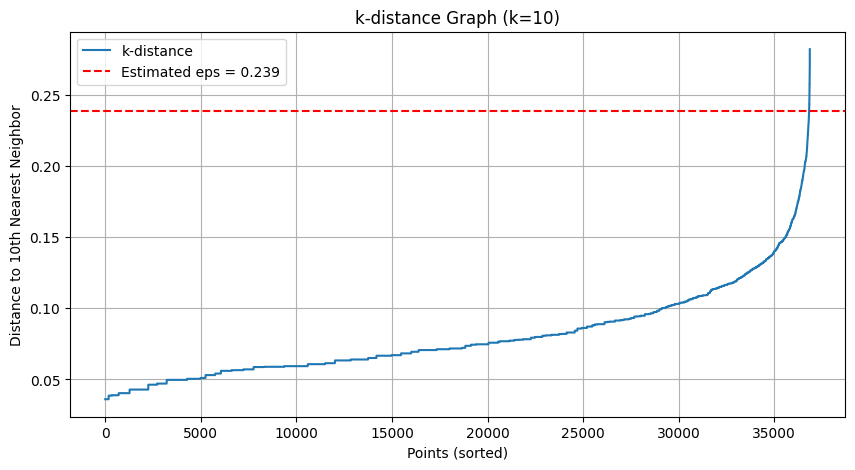

→ eps tối ưu = 0.24, min_samples tối ưu = 150
Đánh giá không giám sát:
Silhouette Score: 0.1328
Davies-Bouldin Index: 1.8947
Calinski-Harabasz Index: 5760.6636
Đánh giá giám sát:
Dice Coefficient: 0.0373
IoU: 0.0190
Precision: 0.0191
Recall: 0.8140
Hausdorff Distance: 132.1363


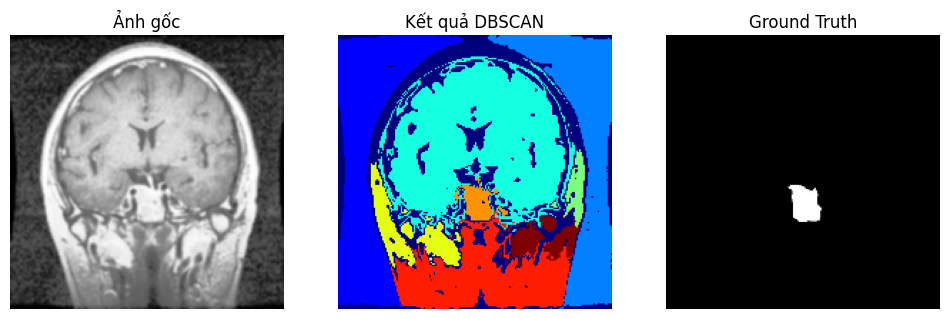

In [81]:
final_results = []
evaluation_results = []

for i, img in enumerate(blurred_images):
    print(f"\n=== Ảnh {i+1} ===")
    h, w = img.shape
    X = np.column_stack((np.indices((h, w)).reshape(2, -1).T, img.flatten()))
    X_scaled = StandardScaler().fit_transform(X)

    # Tìm eps tối ưu
    eps = getEps(X_scaled)

    # Tìm min_samples tối ưu
    min_samples_range = range(10, 300, 10)
    best_min_samples, scores = find_best_min_samples(X_scaled, eps, min_samples_range)
    print(f"→ eps tối ưu = {eps:.2f}, min_samples tối ưu = {best_min_samples}")

    # Áp dụng DBSCAN
    labels = DBSCAN(eps=eps, min_samples=best_min_samples).fit_predict(X_scaled)
    label_img = labels.reshape(h, w)
    final_results.append((img, label_img))

    # Đánh giá không giám sát
    metrics_unsupervised = evaluate_unsupervised(X_scaled, labels)
    print("Đánh giá không giám sát:")
    for metric, value in metrics_unsupervised.items():
        print(f"{metric}: {value:.4f}")

    # Đánh giá giám sát 
    # Lấy thông tin từ đường dẫn ảnh gốc
    image_path = image_files[i]  
    file_name = os.path.basename(image_path)  
    base_name, ext = os.path.splitext(file_name)  
    # Lấy thư mục con (0, 1, 2, hoặc 3)
    sub_dir = os.path.basename(os.path.dirname(image_path))  # Lấy tên thư mục cuối: 0, 1, 2, hoặc 3
    # Tạo đường dẫn ground truth
    mask_base_dir = "./Brain Tumor Segmentation Dataset/mask"
    ground_truth_path = os.path.join(mask_base_dir, sub_dir, f"{base_name}_m{ext}")  

    if os.path.exists(ground_truth_path):
        gt = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
        gt = cv2.resize(gt, size, cv2.INTER_AREA)
        metrics_supervised = evaluate_supervised(label_img, gt)
        print("Đánh giá giám sát:")
        for metric, value in metrics_supervised.items():
            print(f"{metric}: {value:.4f}")
        evaluation_results.append((metrics_unsupervised, metrics_supervised))
    else:
        print(f"Không tìm thấy ground truth tại: {ground_truth_path}")
        evaluation_results.append((metrics_unsupervised, None))

    # Hiển thị kết quả
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Ảnh gốc")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(label_img, cmap='jet')
    plt.title("Kết quả DBSCAN")
    plt.axis('off')
    if os.path.exists(ground_truth_path):
        plt.subplot(1, 3, 3)
        plt.imshow(gt, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
    plt.show()